<a href="https://colab.research.google.com/github/shu65/diffusion-model-book/blob/main/diffusion_model_book_2_3_ddpm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tqdm import tqdm_notebook as tqdm
import torch

device="cpu"

In [2]:
n_samples = int(1e6)
sigma = 0.01

dist0 = torch.distributions.MultivariateNormal(torch.tensor([-2, -2], dtype=torch.float).to(device), sigma*torch.eye(2, dtype=torch.float).to(device))
samples0 = dist0.sample(torch.Size([n_samples//2]))
    
dist1 = torch.distributions.MultivariateNormal(torch.tensor([2, 2], dtype=torch.float).to(device), sigma*torch.eye(2, dtype=torch.float).to(device))
samples1 = dist1.sample(torch.Size([n_samples//2]))
samples = torch.vstack((samples0, samples1))

mean = torch.mean(samples, dim=0)
std = torch.std(samples, dim=0)

normalized_samples = (samples - mean[None, :])/std[None, :]

dataset = torch.utils.data.TensorDataset((normalized_samples))

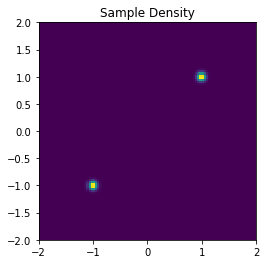

In [3]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt

plot_samples = normalized_samples.cpu().numpy()

plt.hist2d(plot_samples[:,0], plot_samples[:,1], range=((-2, 2), (-2, 2)), cmap='viridis', rasterized=False, bins=100, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.title('Sample Density')
plt.show()

In [4]:
beta_start = 1e-4
beta_end = 0.02
T = 1000

betas = torch.linspace(beta_start, beta_end, T, dtype=torch.float32)
alphas = 1. - betas
alpha_bars = np.cumprod(alphas, axis=0)
beta_bars = 1. - alpha_bars

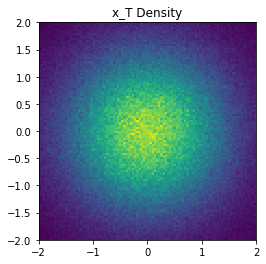

In [5]:
t = torch.full(size=(normalized_samples.shape[0],), fill_value=(T - 1), dtype=torch.int64)
noise = torch.randn_like(normalized_samples)
x = torch.sqrt(alpha_bars[t])[:, None] * normalized_samples + torch.sqrt(beta_bars[t])[:, None] * noise

plot_samples = x.cpu().numpy()

plt.hist2d(plot_samples[:,0], plot_samples[:,1], range=((-2, 2), (-2, 2)), cmap='viridis', rasterized=False, bins=100, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.title('x_T Density')
plt.show()

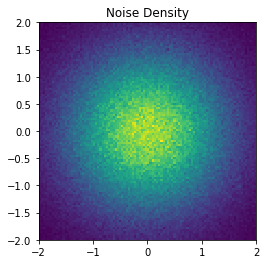

In [6]:
noise = torch.randn_like(x)

plot_samples = noise.cpu().numpy()

plt.hist2d(plot_samples[:,0], plot_samples[:,1], range=((-2, 2), (-2, 2)), cmap='viridis', rasterized=False, bins=100, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.title('Noise Density')
plt.show()

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
  def __init__(self, n_channels=2):
    super(Model, self).__init__()

    self.model = nn.Sequential(
        nn.Linear(n_channels + 1, 2*n_channels),
        nn.ELU(),
        nn.Linear(2*n_channels, 16*n_channels),
        nn.ELU(),
        nn.Linear(16*n_channels, 2*n_channels),
        nn.ELU(),
        nn.Linear(2*n_channels, n_channels),
    )

  def forward(self, x, t):
    h = torch.hstack((x, t[:, None]))
    y = self.model(h)
    return y/sigma

In [13]:
import torch

batch_size = 512
n_steps = 100000

dataloader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=True, num_workers=0)
dataloader_iter = iter(dataloader)

model = Model().to(device)

optimizer = torch.optim.Adam(model.parameters())
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, total_steps=n_steps)
loss_func = torch.nn.MSELoss(reduction="none")

for i in range(n_steps):
  try:
    x0 = next(dataloader_iter)[0]
  except StopIteration:
    dataloader_iter = iter(dataloader)
    x0 = next(dataloader_iter)[0]
  x0 = x0.to(device)

  optimizer.zero_grad()

  noise = torch.randn_like(x0)
  t = torch.randint(0, len(x0), (x0.shape[0],), device=device)
  x = torch.sqrt(alpha_bars[t])[:, None] * x0 + torch.sqrt(beta_bars[t])[:, None] * noise
  noise_pred = model(x, t)
  w = 1.0
  losses = w * loss_func(noise_pred, noise)
  loss = losses.mean()

  loss.backward()
  optimizer.step()
  lr_scheduler.step()
  if (i % 1000) == 0:
    print(f"{i} steps loss:{loss}")


0 steps loss:705960.625
1000 steps loss:4277.56005859375
2000 steps loss:73.47866821289062
3000 steps loss:11.370596885681152
4000 steps loss:2.183591842651367
5000 steps loss:1.2281303405761719
6000 steps loss:1.081244945526123
7000 steps loss:0.8074512481689453
8000 steps loss:0.46669304370880127
9000 steps loss:0.42903101444244385
10000 steps loss:0.42605358362197876
11000 steps loss:0.3836679756641388
12000 steps loss:0.36899763345718384
13000 steps loss:0.48662862181663513
14000 steps loss:0.6280180215835571
15000 steps loss:0.4038073420524597
16000 steps loss:0.42604056000709534
17000 steps loss:3.9266433715820312
18000 steps loss:0.42204520106315613
19000 steps loss:0.4084853529930115
20000 steps loss:0.7029114961624146
21000 steps loss:0.42490726709365845
22000 steps loss:0.4065712094306946
23000 steps loss:0.520219624042511
24000 steps loss:0.5490787029266357
25000 steps loss:0.4169456660747528
26000 steps loss:0.36184608936309814
27000 steps loss:0.4864625930786133
28000 step

In [16]:
def ddpm_sample(n_samples, model, alphas, betas, beta_bars):
    xt = torch.randn(n_samples, 2)
    T = len(alphas)
    for t in range(T -1, -1, -1):
      if (t % 100) == 0:
        print(f"t:{t}")
      ut = torch.randn(n_samples, 2)
      if t == 0:
        ut[:, :] = 0.0
      with torch.no_grad():
        noise_pred = model(xt, t*torch.ones(n_samples, dtype=xt.dtype))
        sigma_t = torch.sqrt(betas[t])
        xt = 1 / torch.sqrt(alphas[t]) * (xt - betas[t]/torch.sqrt(beta_bars[t])*noise_pred) + sigma_t*ut
    return xt

samples_pred = ddpm_sample(n_samples=100000, model=model, alphas=alphas, betas=betas, beta_bars=beta_bars)
samples_pred = samples_pred.cpu().numpy()

t:900
t:800
t:700
t:600
t:500
t:400
t:300
t:200
t:100
t:0


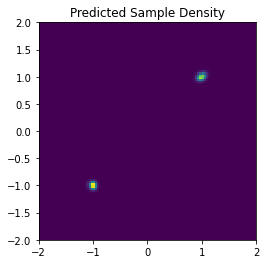

In [15]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt

plt.hist2d(samples_pred[:,0], samples_pred[:,1], range=((-2, 2), (-2, 2)), cmap='viridis', rasterized=False, bins=100, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.title('Predicted Sample Density')
plt.show()